In [1]:
import pandas as pd
import seaborn as se
import pickle
from collections import Counter
import numpy as np
import os
import pickle
from timeit import timeit
import json
from timeit import default_timer as timer
from pathlib import Path
import shutil
import math
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt


In [2]:
se.set_style("darkgrid")

PE Utilization    45.04303
dtype: float64

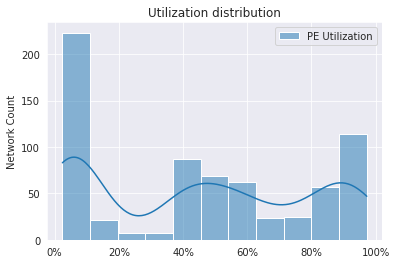

In [3]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

util = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['util'])].mul(100)
util = util.rename(columns={"util": "PE Utilization"})
plt = se.histplot(data = util, kde=True)
plt.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.set_ylabel('Network Count')
plt.set_title('Utilization distribution')
util.mean()

/tmp/ipykernel_145777/720191443.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
/tmp/ipykernel_145777/720191443.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])


Text(0.5, -0.2, 'Contour Plot of Avg. Network PE Utilization & Avg. Network Latency')

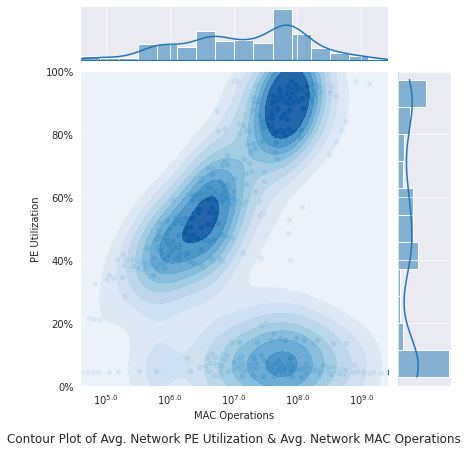

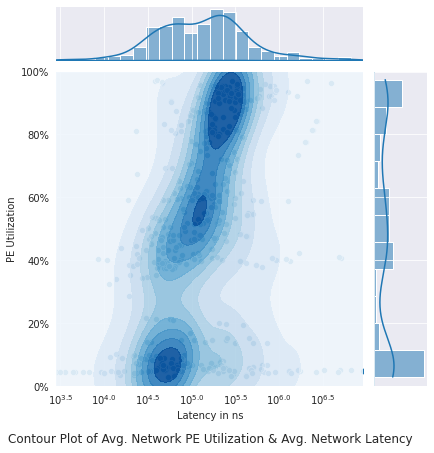

In [4]:
layer_metrics = pd.read_csv('../data/layer_metrics.csv', index_col=[0, 1])
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_2mb.csv', index_col=[0,1],)

util = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['util'])].mul(100)
layer_metrics['macs'] = np.log10(layer_metrics['macs'])
macs_vs_util_df = pd.DataFrame(layer_metrics['macs'].groupby(level=0).mean()).join(util)

plt = se.jointplot(
    data=macs_vs_util_df,
    x="macs",
    y="util",
    kind="kde",
    cmap="Blues",
    zorder=5,
    levels=10,
    alpha=0.9,
    shade=True,
    thresh=0,
    ylim=(0, 100),
    xlim=(
        macs_vs_util_df[["macs"]].min().item(),
        macs_vs_util_df[["macs"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_joint.set_ylabel('PE Utilization')
plt.ax_joint.set_xlabel('MAC Operations')
plt.ax_joint.set_title('Contour Plot of Avg. Network PE Utilization & Avg. Network MAC Operations', y = -0.2)



latency = arch_metrics[['latency']].groupby(level=0).mean()
latency = np.log10(latency)
latency_vs_util = latency.join(arch_metrics[['util']].groupby(level=0).mean().mul(100))

plt = se.jointplot(
    data=latency_vs_util,
    x="latency",
    y="util",
    kind="kde",
    cmap="Blues",
    zorder=5,
    levels=10,
    alpha=0.9,
    shade=True,
    thresh=0,
    ylim=(0, 100),
    xlim=(
        latency_vs_util[["latency"]].min().item(),
        latency_vs_util[["latency"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_joint.set_ylabel('PE Utilization')
plt.ax_joint.set_xlabel('Latency in ns')
plt.ax_joint.set_title('Contour Plot of Avg. Network PE Utilization & Avg. Network Latency', y = -0.2)


In [5]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
).join(layer_properties)

slow_layers_with_high_util = arch_metrics[
    (arch_metrics["speedup"] < 1)
    & (arch_metrics["util"] > 0.85)
    & ((arch_metrics["ifmap_mem_size"] < 2**20))
    & ((arch_metrics["ofmap_mem_size"] < 2**20))
]
slow_layers_with_high_util.to_csv('../data/slow_layers_with_high_util.csv')

/tmp/ipykernel_145777/2210581234.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$2^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
/tmp/ipykernel_145777/2210581234.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$2^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])


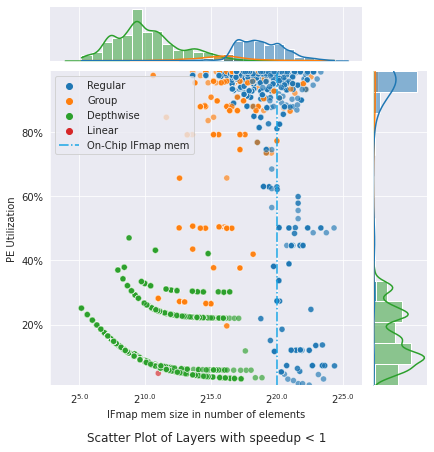

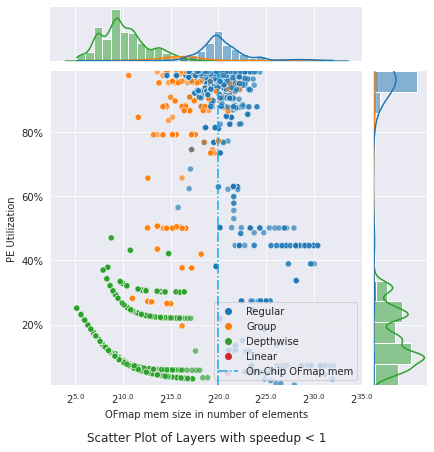

In [112]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
speedup_ub = 1
slow_layers = arch_metrics[arch_metrics["speedup"] < speedup_ub].join(layer_properties)
slow_layers["total_mem_size"] = pd.DataFrame(
    np.log2(slow_layers["ifmap_mem_size"] + slow_layers["ofmap_mem_size"])
)
slow_layers["ifmap_mem"] = pd.DataFrame(np.log2(slow_layers["ifmap_mem_size"]))
slow_layers["ofmap_mem"] = pd.DataFrame(np.log2(slow_layers["ofmap_mem_size"]))
slow_layers["util"] = arch_metrics["util"].mul(100)

slow_layers["Layer Type"] = "Undefined"

depthwise_layers = slow_layers[(slow_layers["groups"] == slow_layers["channels"])]
slow_layers.loc[
    slow_layers.index.isin(depthwise_layers.index), "Layer Type"
] = "Depthwise"

grouped_conv_layers = slow_layers[
    (slow_layers["groups"] != slow_layers["channels"]) & (slow_layers["groups"] > 1)
]
slow_layers.loc[
    slow_layers.index.isin(grouped_conv_layers.index), "Layer Type"
] = "Group"

regular_conv = slow_layers[slow_layers["groups"] == 1]
slow_layers.loc[slow_layers.index.isin(regular_conv.index), "Layer Type"] = "Regular"

non_conv_layers = slow_layers[slow_layers["type"] != "conv"]
slow_layers.loc[slow_layers.index.isin(non_conv_layers.index), "Layer Type"] = "Linear"

plt = se.jointplot(
    data=slow_layers,
    x="ifmap_mem",
    y="util",
    kind="scatter",
    cmap="Blues",
    alpha=0.65,
    ylim=(
        slow_layers[["util"]].min().item(),
        slow_layers[["util"]].max().item(),
    ),
    hue="Layer Type",
)
plt.plot_marginals(se.histplot, zorder=1, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels(
    [r"$2^{" + str(i) + "}$" for i in plt.ax_marg_x.get_xticks()]
)
plt.ax_joint.set_ylabel("PE Utilization")
plt.ax_joint.set_xlabel("IFmap mem size in number of elements")
plt.ax_joint.set_title("Scatter Plot of Layers with speedup < 1", y=-0.2)
plt.ax_joint.axvline(
    x=20, color="#18A5E5", alpha=1, linestyle="-.", zorder=10, label="On-Chip IFmap mem"
)
plt.ax_joint.legend()

plt = se.jointplot(
    data=slow_layers,
    x="ofmap_mem",
    y="util",
    kind="scatter",
    cmap="Blues",
    alpha=0.65,
    ylim=(
        slow_layers[["util"]].min().item(),
        slow_layers[["util"]].max().item(),
    ),
    hue="Layer Type",
)
plt.plot_marginals(se.histplot, zorder=1, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels(
    [r"$2^{" + str(i) + "}$" for i in plt.ax_marg_x.get_xticks()]
)
plt.ax_joint.set_ylabel("PE Utilization")
plt.ax_joint.set_xlabel("OFmap mem size in number of elements")
plt.ax_joint.set_title(f"Scatter Plot of Layers with speedup < {speedup_ub}", y=-0.2)
plt.ax_joint.axvline(
    x=20, color="#18A5E5", alpha=1, linestyle="-.", zorder=10, label="On-Chip OFmap mem"
)
plt.ax_joint.legend()


/tmp/ipykernel_145777/2801054876.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slow_layers = arch_metrics[


Text(0.5, -0.3, 'Types of layers with speedup < 1, memory footprint < $2^{20}$ elements & utilization < 0.5')

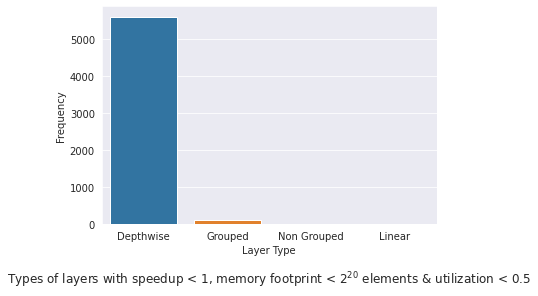

In [325]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
speedup_ub = 1
util_ub = 0.5
slow_layers = arch_metrics[
    (arch_metrics["speedup"] < speedup_ub)
    & (layer_properties["ifmap_mem_size"] < 2**20)
    & (layer_properties["ofmap_mem_size"] < 2**20)
    & (arch_metrics["util"] < util_ub)
].join(layer_properties)

slow_layers["Layer Type"] = "Undefined"

depthwise_layers = slow_layers[(slow_layers["groups"] == slow_layers["channels"])]
slow_layers.loc[
    slow_layers.index.isin(depthwise_layers.index), "Layer Type"
] = "Depthwise"

grouped_conv_layers = slow_layers[
    (slow_layers["groups"] != slow_layers["channels"]) & (slow_layers["groups"] > 1)
]
slow_layers.loc[
    slow_layers.index.isin(grouped_conv_layers.index), "Layer Type"
] = "Group"

regular_conv = slow_layers[slow_layers["groups"] == 1]
slow_layers.loc[slow_layers.index.isin(regular_conv.index), "Layer Type"] = "Regular"

non_conv_layers = slow_layers[slow_layers["type"] != "conv"]
slow_layers.loc[slow_layers.index.isin(non_conv_layers.index), "Layer Type"] = "Linear"

counts = pd.DataFrame(
    {
        "Layer Type": ["Depthwise", "Grouped", "Non Grouped", "Linear"],
        "Frequency": [
            len(depthwise_layers),
            len(grouped_conv_layers),
            len(regular_conv),
            len(non_conv_layers),
        ],
    }
)
plt = se.barplot(data=counts, x="Layer Type", y="Frequency")
plt.set_title(
    r"Types of layers with speedup < 1, memory footprint < $2^{20}$ elements & utilization < " + str(util_ub), y=-0.3
)


/tmp/ipykernel_145777/3638408533.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slow_layers_with_low_util_and_large_footprint = arch_metrics[


Text(0.5, -0.55, 'Reason for low utilization in layers with:\n speedup < 1\nmemory footprint > $2^{20}$\nelements & utilization < 0.5')

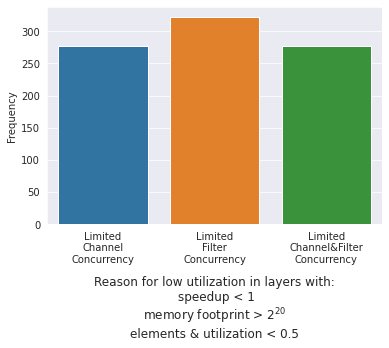

In [364]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
speedup_ub = 1
util_ub = 0.5
slow_layers_with_low_util_and_large_footprint = arch_metrics[
    (arch_metrics["speedup"] < speedup_ub)
    & (arch_metrics["util"] < util_ub)
    & (
        (layer_properties["ifmap_mem_size"] > 2**20)
        | (layer_properties["ofmap_mem_size"] > 2**20)
    )
].join(layer_properties)

single_ifmap_size = (
    slow_layers_with_low_util_and_large_footprint["ifmap_mem_size"]
) / (
    slow_layers_with_low_util_and_large_footprint["in_channels"]
    / slow_layers_with_low_util_and_large_footprint["groups"]
)

single_ofmap_size = (
    slow_layers_with_low_util_and_large_footprint["ofmap_mem_size"]
) / (
    slow_layers_with_low_util_and_large_footprint["out_channels"]
    / slow_layers_with_low_util_and_large_footprint["groups"]
)

slow_layers_with_low_util_and_large_footprint.loc[
    ~slow_layers_with_low_util_and_large_footprint["kernel_size"].isin(
        ["(1, 1)", "(3, 3)"]
    ),
    "kernel_size",
] = "(1, 1)"

ceff = 18 / slow_layers_with_low_util_and_large_footprint["kernel_size"].apply(
    func=lambda x: prod(map(int, x[1:-1].split(",")))
)

max_concurrent_channels = 2**20 / single_ifmap_size
(max_concurrent_channels < ceff).value_counts()

feff = 32
max_concurrent_filters = 2**20 / single_ofmap_size
(max_concurrent_filters < feff).value_counts()

counts = pd.DataFrame(
    {
        "": [
            "Limited\nChannel\nConcurrency",
            "Limited\nFilter\nConcurrency",
            "Limited\nChannel&Filter\nConcurrency",
        ],
        "Frequency": [
            len(
                slow_layers_with_low_util_and_large_footprint[
                    ((max_concurrent_channels < ceff))
                ]
            ),
            len(
                slow_layers_with_low_util_and_large_footprint[
                    ((max_concurrent_filters < feff))
                ]
            ),
            len(
                slow_layers_with_low_util_and_large_footprint[
                    ((max_concurrent_filters < feff) & (max_concurrent_channels < ceff))
                ]
            ),
        ],
    }
)

counts
plt = se.barplot(data=counts, x="", y="Frequency")
plt.set_title(
    "Reason for low utilization in layers with:\n speedup < 1\n" + r"memory footprint > $2^{20}$"+"\nelements & utilization < " + str(util_ub), y=-0.55
)


/tmp/ipykernel_145777/2892161533.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slow_layers_with_high_util = arch_metrics[


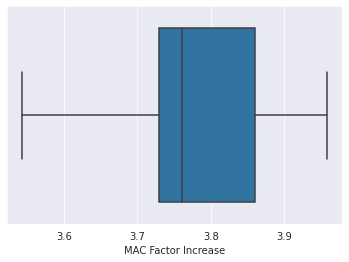

In [377]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
speedup_ub = 1
util_lb = 0.85
slow_layers_with_high_util = arch_metrics[
    (arch_metrics["speedup"] < speedup_ub)
    & (arch_metrics["util"] > 0.85)
    & (layer_properties['lowered/lifted'] == True )
].join(layer_properties)

slow_layers_with_high_util['MAC Factor Increase'] = slow_layers_with_high_util['macs'] / slow_layers_with_high_util['original_macs']

plt = se.boxplot(data=slow_layers_with_high_util, x='MAC Factor Increase', showfliers = False)


/tmp/ipykernel_145777/2094334629.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slow_layers_with_high_util = arch_metrics[
/tmp/ipykernel_145777/2094334629.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
/tmp/ipykernel_145777/2094334629.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_y.set_yticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_y.get_yticks()])


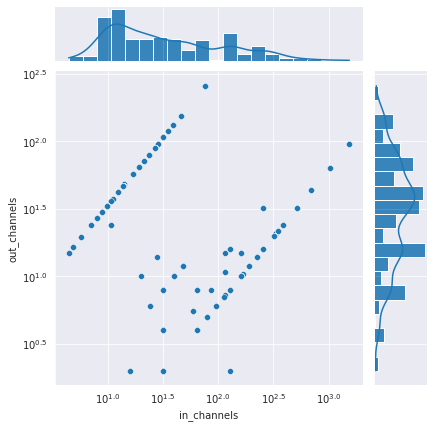

In [387]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
speedup_ub = 1
util_lb = 0.85
slow_layers_with_high_util = arch_metrics[
    (arch_metrics["speedup"] < speedup_ub)
    & (arch_metrics["util"] > 0.85)
    & (layer_properties['lowered/lifted'] == False )
].join(layer_properties)
ceff = 18 / slow_layers_with_high_util["kernel_size"].apply(
    func=lambda x: prod(map(int, x[1:-1].split(",")))
)
feff = 32
slow_layers_with_high_util['in_channels'] = np.log10((slow_layers_with_high_util['in_channels'] / slow_layers_with_high_util['groups'])  / ceff)
slow_layers_with_high_util['out_channels'] = np.log10((slow_layers_with_high_util['out_channels'] / slow_layers_with_high_util['groups']) / feff)
plt = se.jointplot(data=slow_layers_with_high_util, x='in_channels', y='out_channels')
plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_marg_y.set_yticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_y.get_yticks()])
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_joint.set_ylabel('Number of Filters')
plt.ax_joint.set_xlabel('Latency in ns')
plt.ax_joint.set_title('Contour Plot of PE Utilization vs MAC Operations', y = -0.2)


In [216]:
from math import prod
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
speedup_ub = 1
slow_layers = arch_metrics[
    (arch_metrics["speedup"] < speedup_ub)
    & (arch_metrics["util"] > 0.85)
    & (layer_properties["lowered/lifted"] == False)
    # & (layer_properties["ifmap_mem_size"] < 2**20)
    # & (layer_properties["ofmap_mem_size"] < 2**20)
].join(layer_properties)


slow_layers_with_high_util_and_low_filter_count = slow_layers_with_high_util[
    (slow_layers_with_high_util["out_channels"] / slow_layers_with_high_util["groups"])
    <= 32
].copy()
slow_layers_with_high_util_and_low_filter_count.loc[:, 'macs_per_channel'] =  slow_layers_with_high_util_and_low_filter_count['kernel_size'].apply(
    func=lambda x: prod(map(int, x[1:-1].split(",")))
)
slow_layers_with_high_util_and_low_filter_count['ceff'] = 18 / slow_layers_with_high_util_and_low_filter_count['macs_per_channel']
(slow_layers_with_high_util_and_low_filter_count['in_channels'] > slow_layers_with_high_util_and_low_filter_count['ceff']).value_counts()

/tmp/ipykernel_145777/2043439521.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slow_layers = arch_metrics[


True    123
dtype: int64

Text(0.5, -0.3, 'Reason for layers experiencing Speedup < 1 over CPU Baseline')

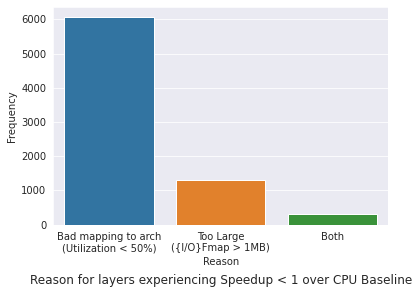

In [34]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_metrics = pd.read_csv(
    "../data/layer_metrics.csv",
    index_col=[0, 1],
)
arch_metrics = arch_metrics[arch_metrics["speedup"] < 1]
layer_metrics = layer_metrics[layer_metrics.index.isin(arch_metrics.index)]
slow_layers = arch_metrics.join(layer_metrics)
slow_layers["ifmap_huge"] = slow_layers["ifmap_mem_size"] > 2**20
slow_layers["ofmap_huge"] = slow_layers["ofmap_mem_size"] > 2**20
slow_layers["layer_huge"] = (slow_layers["ifmap_mem_size"] > 2**20) & (slow_layers["ofmap_mem_size"] > 2**20)
slow_layers["low_util"] = slow_layers["util"] < 0.5
slow_layers["high_util"] = slow_layers["util"] > 0.95

not_enough_pes = len(slow_layers[slow_layers["util"] > 0.85])
bad_mapping = len(slow_layers[slow_layers["util"] < 0.5])
too_large = len(
    slow_layers[
        (slow_layers["ifmap_huge"] == True) | (slow_layers["ofmap_huge"] == True)
    ]
)
both = len(
    slow_layers[
        ((slow_layers["ifmap_huge"] == True) | (slow_layers["ofmap_huge"] == True))
        & (slow_layers["util"] < 0.5)
    ]
)

counts = pd.DataFrame(
    {
        "Reason": [
            "Bad mapping to arch\n(Utilization < 50%)",
            "Too Large\n({I/O}Fmap > 1MB)",
            "Both",
        ],
        "Frequency": [bad_mapping, too_large, both],
    }
)
plt = se.barplot(data=counts, x="Reason", y="Frequency")
plt.set_title("Reason for layers experiencing Speedup < 1 over CPU Baseline", y=-0.3)